<a href="https://colab.research.google.com/github/AshorYaghob/Neural_Style_Transfer/blob/main/Neural_Style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

# **Load VGG Weights**


---

You want to use TensorFlow to load a VGG 19 model, which is a deep Convolutional Neural Network.

Training your own models paramaters is too time consuming and computationally expensive. TensorFlow has built in paramaters for the VGG 19 model that was trained on the ImageNet dataset.

Make sure include_top is false, as this is not actually a classification problem, we just want the models capability to detect low and high level features.

In [ ]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
<Functional name=vgg19, built=True>


# **Content Cost Function**


---

This is the cost function for content. It measures how well the content of the generated image matches the content of the original image.

In [ ]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost

    Arguments:
    act_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    act_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    Returns:
    cost_content -- scalar you compute that represents the content cost of 1 layer.
    """
    act_C = content_output[-1]
    act_G = generated_output[-1]

    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = act_G.get_shape().as_list()

    # Reshape 'a_C' and 'a_G' into 2d matrices (element-wise calculations easier)
    act_C_unrolled = tf.reshape(act_C, [-1, n_C])
    act_G_unrolled = tf.reshape(act_G, [-1, n_C])

    # compute the cost with tensorflow functions
    cost_content = tf.reduce_sum(tf.square(tf.subtract(act_C_unrolled, act_G_unrolled))) / (4.0 * n_H * n_W * n_C)

    return cost_content

# **Style Cost Function**


---



1.   Create a function for computing the gram matrix. this is neccessary for computing the Style cost function as its a way to measure correlation between layers.
2.   Create a function for the style cost for one layer. This compares the gram matrices of the generated image to the style image.


Corellation between channels is important in imitating the style of an image. If each channel is the result of a filter convolving an input, then each layer has a role in detecting a feature of an image. The correlation measures how likely one feature is going to exist if another one does, this helps our Neural Network learn how to imitate the style of our style Image and apply it to the Generated image.



In [ ]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)

    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A, tf.transpose(A))

    return GA

In [ ]:
def compute_layer_style_cost(act_S, act_G):
    """
    Arguments:
    act_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    act_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns:
    cost_style_layer -- tensor representing a scalar value
    """
    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = act_G.get_shape().as_list()

    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W)
    act_S = tf.transpose(tf.reshape(act_S, [-1, n_C]))
    act_G = tf.transpose(tf.reshape(act_G, [-1, n_C]))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(act_S)
    GG = gram_matrix(act_G)

    # Computing the loss
    cost_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) / (4.0 * (n_C ** 2) * (n_H * n_W) ** 2)

    return cost_style_layer

# **A Look Into The Layers**

---

Lets take a look at the layers of the VGG 19 Model. You can then choose which layers you want for your style layers, and what you want for the content layer.

In [ ]:
for layer in vgg.layers:
    print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
vgg.get_layer('block5_conv4').output

<KerasTensor shape=(None, 25, 25, 512), dtype=float32, sparse=False, name=keras_tensor_20>

In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

# **Calculating Style Cost For Multiple Layers**

---

Often times having only 1 style layer doesnt capture enough detail to transfer onto your generated image. You want a mix of shallow and deep layers from your Convolutional Network.

If you want your image to strongly imitate the style image, choose smaller weights for deep layers and larger weights for the first layers.

If you want your image to 'Softly' imitate the style image, choose larger weights for deeper layers and smaller weights for the first layers.

For the content layer, one layer is sufficcient, multiple layers is not necessary.

In [ ]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them

    Returns:
    cost_style -- tensor representing a scalar value. Represents the style cost of multiple layers.
    """

    # initialize the overall style cost
    cost_style = 0

    # Set act_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    act_S = style_image_output[:-1]

    # Set act_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    act_G = generated_image_output[:-1]
    for i, weight in zip(range(len(act_S)), STYLE_LAYERS):
        # Compute style_cost for the current layer
        cost_style_layer = compute_layer_style_cost(act_S[i], act_G[i])

        # Add weight * cost_style_layer of this layer to overall style cost
        cost_style += weight[1] * cost_style_layer

    return cost_style

# **Total Cost Function**

---

Now we combine the cost function for the style and content into one cost function , and attach hyperparamaters (coefficients) to the content and style cost function to tell the model how much we prioritize each.


$$T_{cost}(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [ ]:
@tf.function()
def total_cost(cost_content, cost_style, alpha = 10, beta = 40):
    """
    Computes the total cost function

    Arguments:
    cost_content -- content cost coded above
    cost_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    Returns:
    T_Cost -- total cost as defined by the formula above.
    """

    T_Cost = alpha * cost_content + beta * cost_style

    return T_Cost

# **Load Content & Style Image**

(1, 400, 400, 3)


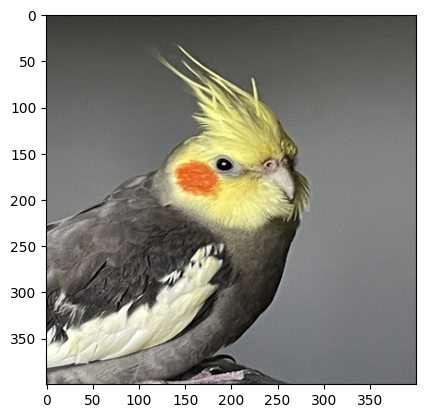

In [ ]:
content_image = np.array(Image.open("bird2.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


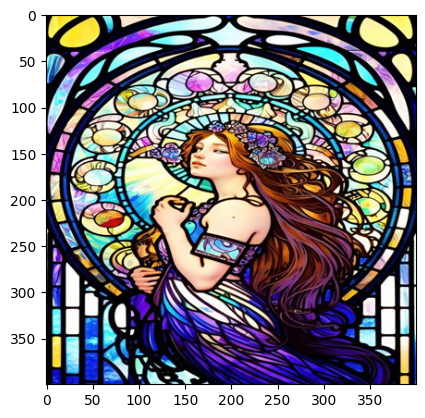

In [ ]:
style_image =  np.array(Image.open("cathedral_style.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

# **Randomly Initialize Generated Image**

(1, 400, 400, 3)


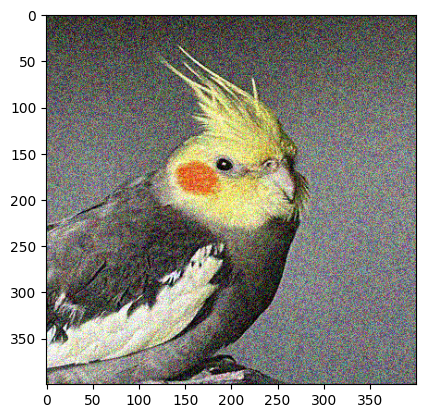

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

# **Load Pre-Trained Model**

In [ ]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

NameError: name 'get_layer_outputs' is not defined

In [ ]:
# Assign the content image to be the input of the VGG model.
# Set act_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
act_C = vgg_model_outputs(preprocessed_content)

In [ ]:
# Assign the input of the model to be the "style" image
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
act_S = vgg_model_outputs(preprocessed_style)

# **Functions For Display**

---

The following 2 functions are needed for:


1.   Normalizing the range of the pixel values to the range 0
2.   Returning the normalized values back to the normal pixel range and turning them into a PIL(Python Imaging Library) Image.

In [ ]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1

    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image

    Arguments:
    tensor -- Tensor

    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

# **Define The Training Function.**

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # Compute a_G as the vgg_model_outputs for the current generated image
        act_G = vgg_model_outputs(generated_image)

        # Compute the style cost
        cost_style = compute_style_cost(act_S, act_G)

        #(2 lines)
        # Compute the content cost
        cost_content = compute_content_cost(act_C, act_G)
        # Compute the total cost
        T_cost = total_cost(cost_content, cost_style, 10, 40)


    grad = tape.gradient(T_cost, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    #Can potentially remove return function
    return T_cost

# **Train the Model.**

In [ ]:
generated_image = tf.Variable(generated_image)

Epoch 0 


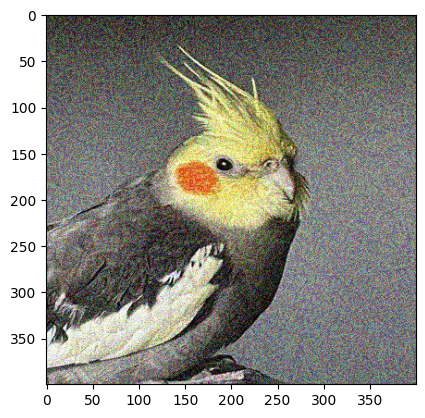

Epoch 250 


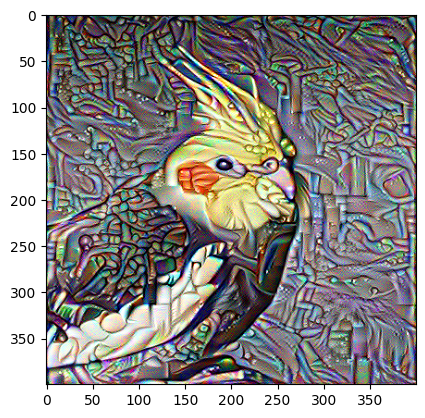

Epoch 500 


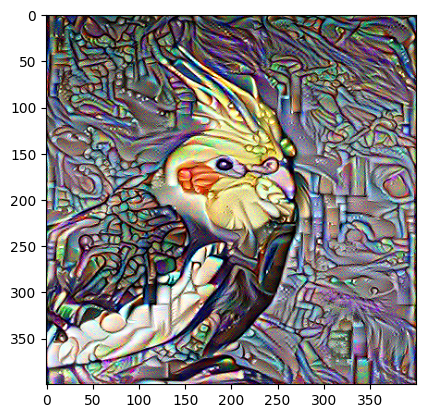

Epoch 750 


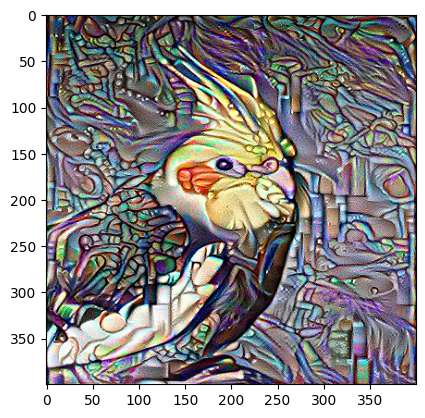

Epoch 1000 


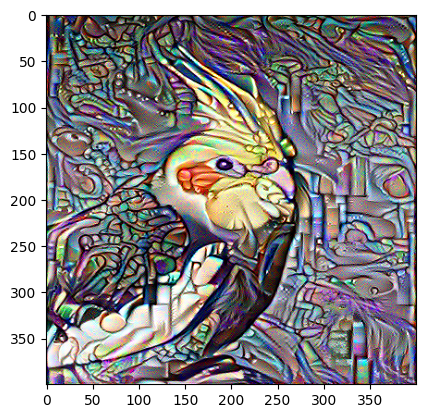

Epoch 1250 


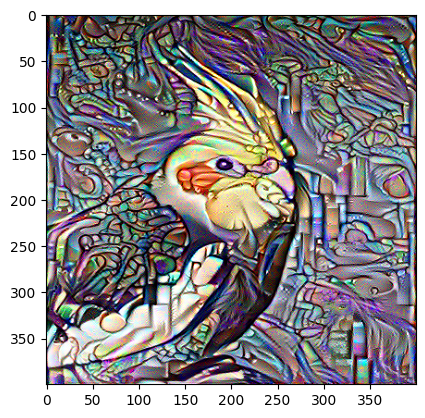

Epoch 1500 


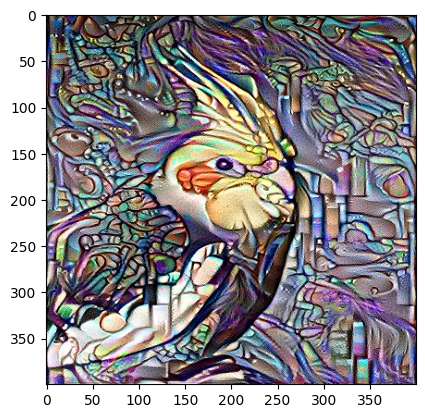

Epoch 1750 


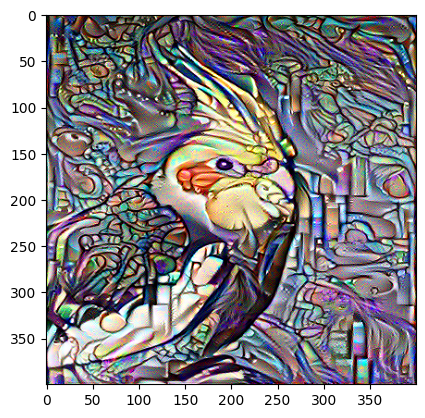

Epoch 2000 


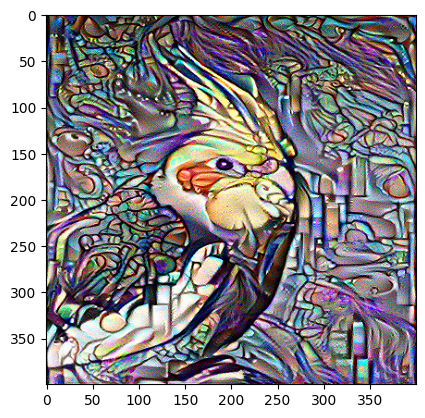

Epoch 2250 


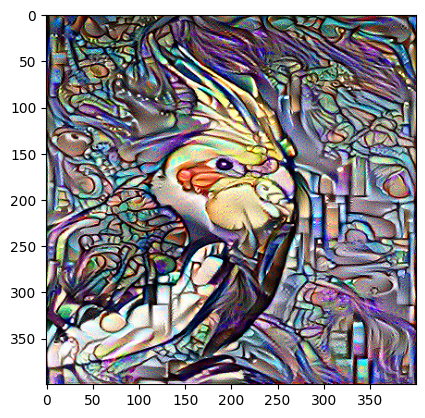

Epoch 2500 


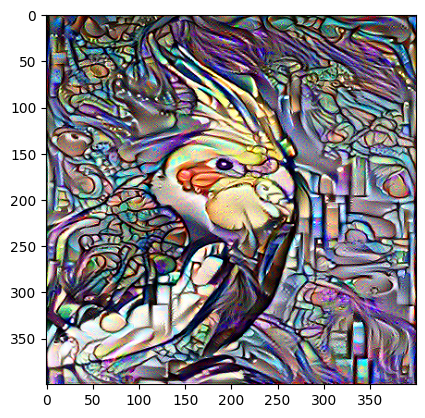

In [ ]:
# Show the generated image at some epochs
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"image_{i}.jpg")
        plt.show()

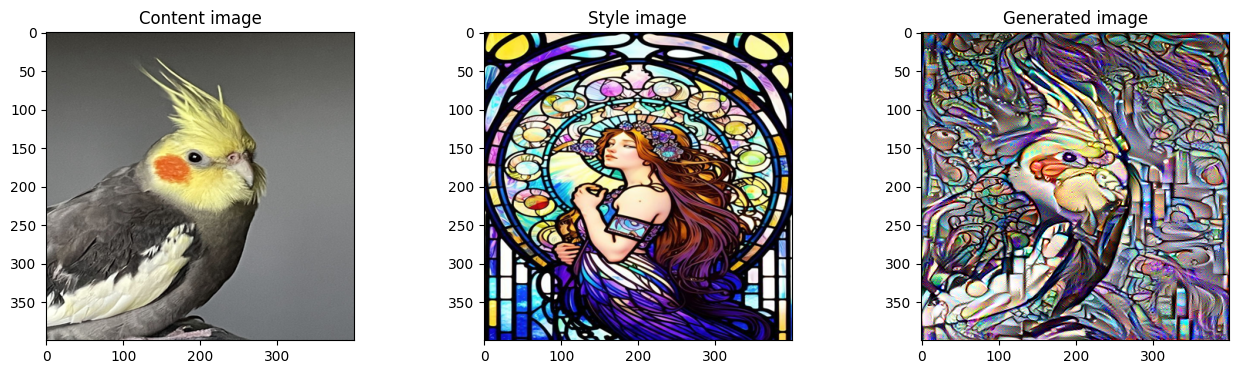

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()